# **Airtel Stock Prediction Models - Daily**

Models Analyzed: 
1.   Random Forest Regressor
2.   Adaboost Regressor
3.   Keras Regressor 
4.   ARIMA
5.   ML Pipeline



**Import necessary libraries**

In [60]:
import warnings 
warnings.filterwarnings("ignore")

In [61]:
# Basic and Visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Regressor models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

# Keras and Neural Networks
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import Adam
from keras.layers import Dropout

# Autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Auto Regressive Integrated Moving Average
from statsmodels.tsa.arima_model import ARIMA

# Pipeline model
from sklearn.pipeline import Pipeline

In [62]:
# Read csv file
df_stock = pd.read_csv('BHARTIAIRTEL.csv')
df_stock.head()

,Symbol,Series,Date,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,Total Traded Quantity,Turnover,No. of Trades,Deliverable Qty,% Dly Qt to Traded Qty
0,BHARTIARTL,EQ,04-Nov-22,818.65,815.70,821.80,809.20,816.10,816.40,814.59,3768226,3.069542e+09,90470,2243180,59.53
1,BHARTIARTL,BL,03-Nov-22,802.10,809.85,809.85,809.85,809.85,809.85,809.85,3400871,2.754195e+09,1,-,-
2,BHARTIARTL,EQ,03-Nov-22,809.85,809.75,824.40,804.20,817.50,818.65,817.78,5897840,4.823129e+09,160802,3380905,57.32
3,BHARTIARTL,EQ,31-Oct-22,816.85,823.00,833.80,820.00,832.00,832.00,829.27,5487233,4.550408e+09,166517,3411499,62.17
4,BHARTIARTL,EQ,28-Oct-22,817.10,819.00,824.40,811.30,819.50,816.85,816.70,3905093,3.189280e+09,106794,1890500,67.1


**Exploratory Data Analysis (EDA)**

In [63]:
df_stock.shape

(1743, 15)

In [64]:
df_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1743 entries, 0 to 1742
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Symbol                  1743 non-null   object 
 1   Series                  1743 non-null   object 
 2   Date                    1743 non-null   object 
 3   Prev Close              1743 non-null   float64
 4   Open Price              1743 non-null   float64
 5   High Price              1743 non-null   float64
 6   Low Price               1743 non-null   float64
 7   Last Price              1743 non-null   float64
 8   Close Price             1743 non-null   float64
 9   Average Price           1743 non-null   float64
 10  Total Traded Quantity   1743 non-null   int64  
 11  Turnover                1743 non-null   float64
 12  No. of Trades           1743 non-null   int64  
 13  Deliverable Qty         1743 non-null   object 
 14  % Dly Qt to Traded Qty  1743 non-null   

Insights: 1. No null values in the dataset. 
2. Need to remove Series values other than 'EQ'
3. Need to remove columns which are not useful for price predictions i.e. remove columns other than 'Date' and 'Close Price'
4. 'Close Price' column to be renamed to 'Close_Price'
5. Date column type to be changed from object to Date 
5. Sort data in ascending order of date
6. Set Date column as new index

In [65]:
# Dropping all Series column values which are not equal to 'EQ'
values=['EQ']
df_stock = df_stock[df_stock['Series'].isin(values)]

In [66]:
df_stock = df_stock[['Date', 'Close Price' ]]

In [67]:
# Renaming of column name 'Close Price'
df_stock = df_stock.rename(columns={'Close Price': 'Close_Price'})
df_stock.head()

,Date,Close_Price
0,04-Nov-22,816.40
2,03-Nov-22,818.65
3,31-Oct-22,832.00
4,28-Oct-22,816.85
5,27-Oct-22,817.10


In [68]:
df_stock.nunique()

Date           1726
Close_Price    1492
dtype: int64

In [69]:
# Find all duplicate rows
df_stock[df_stock.duplicated()]

,Date,Close_Price
756,04-Nov-19,378.00
1498,03-Nov-16,308.95
1500,02-Nov-16,309.60
1502,01-Nov-16,317.45


In [70]:
# Remove duplicate rows
df_stock = df_stock.drop_duplicates()
df_stock.nunique()

Date           1726
Close_Price    1492
dtype: int64

In [71]:
df_stock['Date'] = pd.to_datetime(df_stock['Date'])
df_stock.head()

,Date,Close_Price
0,2022-11-04,816.40
2,2022-11-03,818.65
3,2022-10-31,832.00
4,2022-10-28,816.85
5,2022-10-27,817.10


In [72]:
# Set Date column as index 
df_stock=df_stock.set_index(pd.DatetimeIndex(df_stock['Date']))
df_stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1726 entries, 2022-11-04 to 2015-11-09
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         1726 non-null   datetime64[ns]
 1   Close_Price  1726 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 40.5 KB


In [73]:
# Sort index in ascending order
df_stock = df_stock.sort_index(ascending=True)
df_stock.head()

,Date,Close_Price
Date,,
2015-11-09,2015-11-09,335.25
2015-11-10,2015-11-10,331.65
2015-11-11,2015-11-11,331.90
2015-11-13,2015-11-13,333.90
2015-11-16,2015-11-16,335.75


In [74]:
# Providing data range for understanding
print(f'Dataframe contains stock prices between {df_stock.Date.min().strftime("%Y-%m-%d")} and {df_stock.Date.max().strftime("%Y-%m-%d")}')
print(f'Total days {(df_stock.Date.max() - df_stock.Date.min()).days} days')

Dataframe contains stock prices between 2015-11-09 and 2022-11-04
Total days 2552 days


In [75]:
df_stock['Date']= pd.to_datetime(df_stock["Date"]).dt.strftime("%Y%m%d")
df_stock.head()

,Date,Close_Price
Date,,
2015-11-09,20151109,335.25
2015-11-10,20151110,331.65
2015-11-11,20151111,331.90
2015-11-13,20151113,333.90
2015-11-16,20151116,335.75


In [76]:
df_stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1726 entries, 2015-11-09 to 2022-11-04
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1726 non-null   object 
 1   Close_Price  1726 non-null   float64
dtypes: float64(1), object(1)
memory usage: 40.5+ KB


In [77]:
# Convert Date column to integer
df_stock['Date'] = df_stock['Date'].astype('int64')

In [78]:
df_stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1726 entries, 2015-11-09 to 2022-11-04
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1726 non-null   int64  
 1   Close_Price  1726 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 40.5 KB


**Finding Outliers and Treatment**

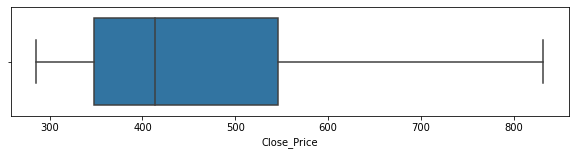

In [79]:
# Boxplot
plt.figure(figsize=(10,2))
ax = sns.boxplot(x=df_stock['Close_Price'],whis=1.5,data=df_stock)

Insight: No outliers in the dataset

**Data Visualizations**

**Histogram**

<Figure size 576x288 with 0 Axes>

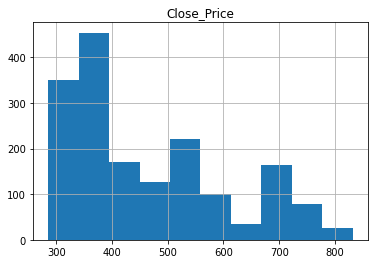

In [80]:
plt.figure(figsize=(8,4))
df_stock.hist("Close_Price")
plt.show()

**Density Plot**

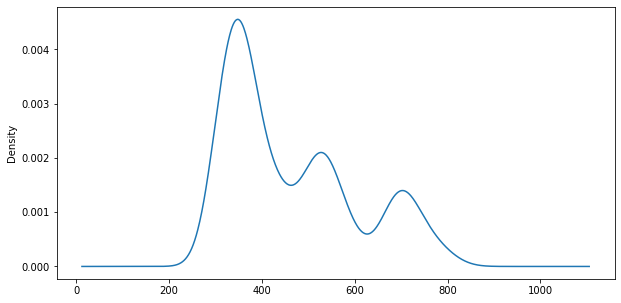

In [81]:
plt.figure(figsize=(10,5))
df_stock["Close_Price"].plot(kind='kde')
plt.show()

**Scatter Plot**

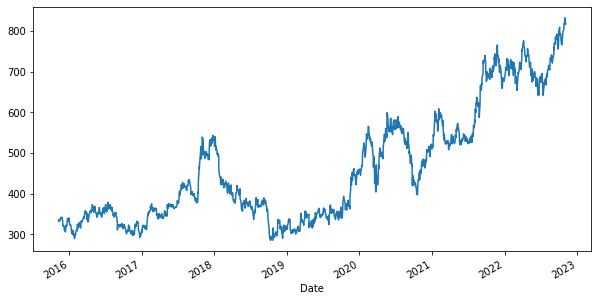

In [82]:
plt.figure(figsize=(10,5))
df_stock['Close_Price'].plot()
plt.show()

Insight: Trend is upword or positive. Seasonality can be observed slightly.

**Correlation between variables**

In [83]:
df_stock.corr()

,Date,Close_Price
Date,1.000000,0.830831
Close_Price,0.830831,1.000000


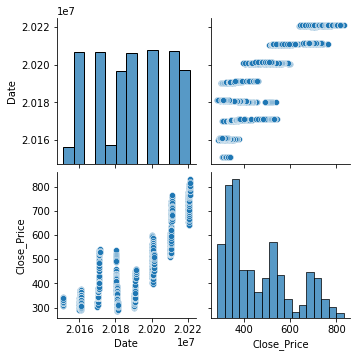

In [84]:
sns.pairplot(df_stock)

Final Conclusion: Have significant relationship exists between Data and Close_Price

**Analysis and Splitting of Data into Train and Test**

In [85]:
df_stock.tail(19)

,Date,Close_Price
Date,,
2022-10-06,20221006,788.60
2022-10-07,20221007,793.10
2022-10-10,20221010,792.35
2022-10-11,20221011,780.30
2022-10-12,20221012,775.55
2022-10-13,20221013,768.90
2022-10-14,20221014,765.95
2022-10-17,20221017,766.00
2022-10-18,20221018,783.15


In [86]:
# We can use one month data for predicting/forecasting. Timeseries data may not do perfectly too long predictions 
# Actual values varies on a lot of other reasons other than momentum.
n=19
split_at = len(df_stock)-n
print ('splitting the dataset at: ', split_at)

df_stock_train = df_stock.iloc[0:split_at, :]
df_stock_test = df_stock.iloc[split_at:, :]

# Create separate train dataset for Arima use since we append data while forecasting
df_stock_train_arima = df_stock.iloc[0:split_at, :]

splitting the dataset at:  1707


In [87]:
print(df_stock_train.info())
print(df_stock_train_arima.info())
print(df_stock_test.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1707 entries, 2015-11-09 to 2022-10-04
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1707 non-null   int64  
 1   Close_Price  1707 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 40.0 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1707 entries, 2015-11-09 to 2022-10-04
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1707 non-null   int64  
 1   Close_Price  1707 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 40.0 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19 entries, 2022-10-06 to 2022-11-04
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         19 non-null     int64  
 1   Close_Price  19 non-null     float64
dtypes: float6

In [88]:
df_stock_train.tail()

,Date,Close_Price
Date,,
2022-09-28,20220928,761.45
2022-09-29,20220929,764.65
2022-09-30,20220930,799.90
2022-10-03,20221003,803.35
2022-10-04,20221004,808.70


In [89]:
df_stock_test.head()

,Date,Close_Price
Date,,
2022-10-06,20221006,788.60
2022-10-07,20221007,793.10
2022-10-10,20221010,792.35
2022-10-11,20221011,780.30
2022-10-12,20221012,775.55


In [90]:
df_stock_train_x = df_stock_train['Date']
df_stock_train_y = df_stock_train['Close_Price']

df_stock_train_array_x = df_stock_train_x.values.reshape(-1,1)
df_stock_train_array_y = df_stock_train_y.values.reshape(-1,1)

## **Random Forest Regressor Model**

In [91]:
rf_model = RandomForestRegressor(n_estimators = 300, max_depth = 7, 
                                 random_state = 18)
rf_model.fit(df_stock_train_array_x, df_stock_train_array_y)

RandomForestRegressor(max_depth=7, n_estimators=300, random_state=18)

**Prediction**

In [92]:
df_stock_test_array_x = df_stock_test['Date'].values.reshape(-1,1)

In [93]:
# Prediction
pred_test = rf_model.predict(df_stock_test_array_x)

In [94]:
pred_test

array([803.98415397, 803.98415397, 803.98415397, 803.98415397,
       803.98415397, 803.98415397, 803.98415397, 803.98415397,
       803.98415397, 803.98415397, 803.98415397, 803.98415397,
       803.98415397, 803.98415397, 803.98415397, 803.98415397,
       803.98415397, 803.98415397, 803.98415397])

**Evaluation of Model**

In [95]:
mse = mean_squared_error(df_stock_test['Close_Price'], pred_test)
rmse_rf = mse**.5
print(mse)
print(rmse_rf)

447.4533793590533
21.15309384839611


**Understanding the predictions by charts**

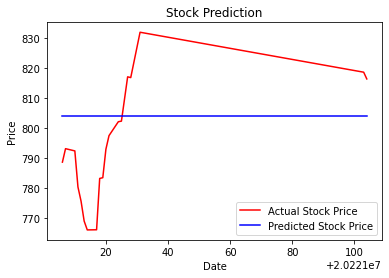

In [96]:
plt.plot(df_stock_test['Date'], df_stock_test['Close_Price'], color='red', label='Actual Stock Price')
plt.plot(df_stock_test['Date'], pred_test, color='blue', label='Predicted Stock Price')
plt.title('Stock Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## **Adaboost Regressor**

In [97]:
# Choosing Decision Tree with one level as weak learner
dtr = DecisionTreeRegressor(max_depth=7)

In [98]:
# Adaboost Regressor
model_adaboost = AdaBoostRegressor(n_estimators=50, base_estimator=dtr, learning_rate=0.001, loss='linear') 
print(model_adaboost)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=7),
                  learning_rate=0.001)


In [99]:
# Fitting the model on training data
model_adaboost.fit(df_stock_train_array_x, df_stock_train_array_y)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=7),
                  learning_rate=0.001)

In [100]:
# Predict on test data now
pred_test_ab = model_adaboost.predict(df_stock_test_array_x) 

In [101]:
pred_test_ab

array([805.64285714, 805.64285714, 805.64285714, 805.64285714,
       805.64285714, 805.64285714, 805.64285714, 805.64285714,
       805.64285714, 805.64285714, 805.64285714, 805.64285714,
       805.64285714, 805.64285714, 805.64285714, 805.64285714,
       805.64285714, 805.64285714, 805.64285714])

**Evaluation of Adaboost Model**

In [102]:
mse = mean_squared_error(df_stock_test['Close_Price'], pred_test_ab)
rmse_ab = mse**.5
print(mse)
print(rmse_ab)

482.0952389903324
21.956667301535823


**Understanding the predictions by charts (Adaboost)**

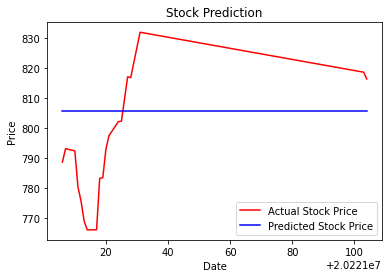

In [103]:
plt.plot(df_stock_test['Date'], df_stock_test['Close_Price'], color='red', label='Actual Stock Price')
plt.plot(df_stock_test['Date'], pred_test_ab, color='blue', label='Predicted Stock Price')
plt.title('Stock Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## **Neural Networks**

In [104]:
# Defining the baseline_model

def baseline_model():
    model = Sequential()
    model.add(Dense(13,input_dim = 1, activation = 'linear'))
    model.add(Dropout(0.1))
    model.add(Dense(7, activation = 'linear'))
    model.add(Dropout(0.1))
    model.add(Dense(1,activation = 'linear'))
    
    adam = Adam(lr = 0.001) 
    model.compile(loss = 'mean_squared_error',optimizer = adam, metrics = ['mse'])
    return model


In [105]:
# Create the model
model_kr = KerasRegressor(build_fn = baseline_model, verbose = 0, batch_size = 20, epochs = 100)
history = model_kr.fit(df_stock_train_array_x, df_stock_train_array_y)

In [106]:
# Prediction
pred_test_kr = model_kr.predict(df_stock_test_array_x)

In [107]:
pred_test_kr

array([1121.3912, 1121.3918, 1121.3915, 1121.3951, 1121.3951, 1121.3951,
       1121.3932, 1121.3936, 1121.3927, 1121.3927, 1121.3927, 1121.3927,
       1121.3942, 1121.3942, 1121.3944, 1121.3944, 1121.3951, 1121.3976,
       1121.3983], dtype=float32)

**Evaluation of Keros Regresssor Model**

In [108]:
mse = mean_squared_error(df_stock_test['Close_Price'], pred_test_kr)
rmse_kr = mse**.5
print(mse)
print(rmse_kr)

107299.01208630852
327.565279122053


**Understanding the predictions by charts (Keros Regressor)**

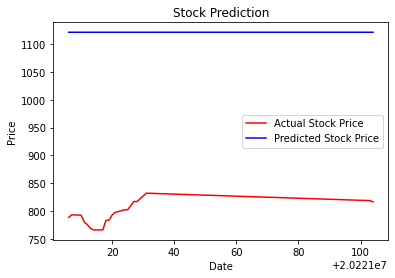

In [109]:
plt.plot(df_stock_test['Date'], df_stock_test['Close_Price'], color='red', label='Actual Stock Price')
plt.plot(df_stock_test['Date'], pred_test_kr, color='blue', label='Predicted Stock Price')
plt.title('Stock Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## **ARIMA (Auto Regressive Integrated Moving Average)**

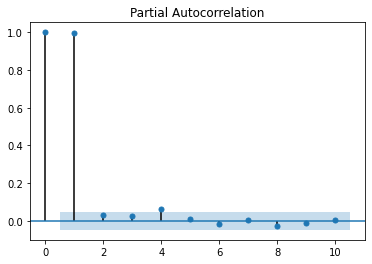

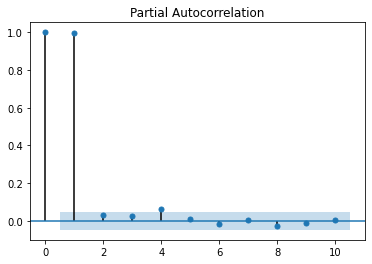

In [110]:
# Plot PACF to choose right p value for Arima order (Auto Regression)
plot_pacf(df_stock_train_arima['Close_Price'], lags=10)

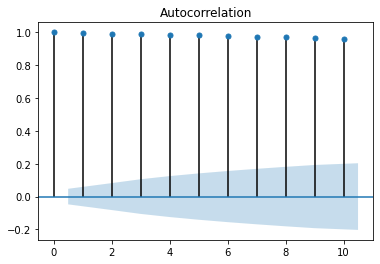

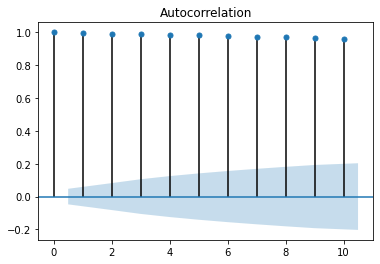

In [111]:
# Plot ACF to choose right q value for Arima order (Moving Average)
plot_acf(df_stock_train_arima['Close_Price'], lags=10)

Insights: PACF Plot reduced exponentially at 2 from 0. So, p value of 2 will be considered.

ACF plot looks better at 10, which is maximum lag. So, q value of 10 will be considered.

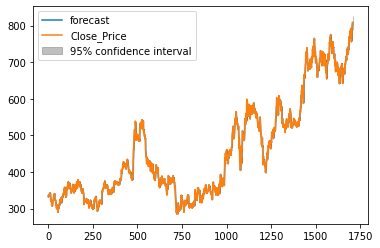

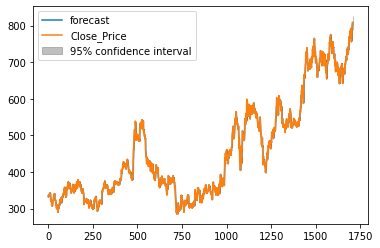

In [112]:
model_arima = ARIMA(df_stock_train_arima['Close_Price'], order=(2,0,10))
model_arima_fit = model_arima.fit()
forecast = model_arima_fit.forecast(steps=len(df_stock_test))[0]
pred_arima = model_arima_fit.predict(start=1, end=len(df_stock_train_arima))
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)
model_arima_fit.plot_predict(1,len(df_stock_train_arima))

In [113]:
pred_arima

1       335.485429
2       332.046166
3       332.263303
4       334.075654
5       335.795094
           ...    
1703    761.376203
1704    763.370397
1705    797.142830
1706    801.381786
1707    806.862303
Length: 1707, dtype: float64

In [114]:
df_stock_train_arima = df_stock_train_arima.append(df_stock_test, ignore_index = True)
print(len(df_stock_train_arima))
print(len(df_stock_test))

1726
19


In [115]:
df_stock_train_arima.iloc[1707:, :]

,Date,Close_Price
1707,20221006,788.60
1708,20221007,793.10
1709,20221010,792.35
1710,20221011,780.30
1711,20221012,775.55
1712,20221013,768.90
1713,20221014,765.95
1714,20221017,766.00
1715,20221018,783.15
1716,20221019,783.40


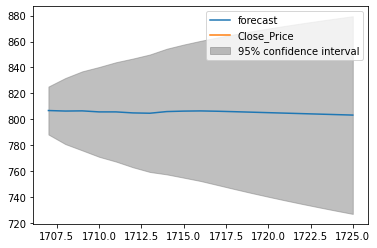

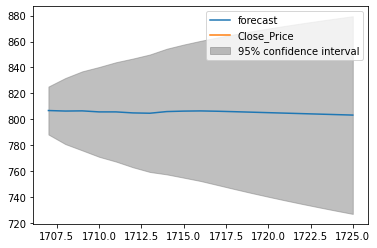

In [116]:
pred_test_arima = model_arima_fit.predict(start=split_at, end=len(df_stock_train_arima)-1)
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)
model_arima_fit.plot_predict(split_at,len(df_stock_train_arima)-1)

In [117]:
pred_test_arima

1707    806.862303
1708    806.461266
1709    806.601081
1710    805.805382
1711    805.809522
1712    805.028861
1713    804.783738
1714    806.066442
1715    806.416590
1716    806.561181
1717    806.312480
1718    805.967812
1719    805.600003
1720    805.226888
1721    804.852837
1722    804.478919
1723    804.105395
1724    803.732329
1725    803.359737
dtype: float64

In [118]:
print(forecast)
print(len(forecast))

[806.86230337 806.46126608 806.60108102 805.80538202 805.8095219
 805.02886137 804.7837379  806.06644165 806.41658999 806.56118128
 806.31248025 805.96781242 805.60000274 805.2268881  804.85283692
 804.47891872 804.10539498 803.7323293  803.35973679]
19


Observation: Results of forecast and prediction of new values after appending into train dataset are same.

**Evaluation of Arima Model**

In [119]:
mse = mean_squared_error(df_stock_test['Close_Price'], pred_test_arima)
rmse_arima = mse**.5
print(mse)
print(rmse_arima)

501.3018524980821
22.389771157787255


**Understanding the predictions by charts (Arima)**

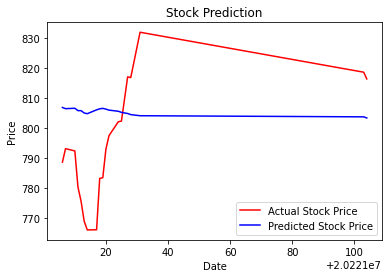

In [120]:
plt.plot(df_stock_test['Date'], df_stock_test['Close_Price'], color='red', label='Actual Stock Price')
plt.plot(df_stock_test['Date'], pred_test_arima, color='blue', label='Predicted Stock Price')
plt.title('Stock Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## **Pipeline model-1**

In [121]:
from sklearn.pipeline import make_pipeline

pipe_rf = RandomForestRegressor(n_estimators = 300, max_depth = 7, random_state = 18)

dtr = DecisionTreeRegressor(max_depth=7)
pipe_ab = AdaBoostRegressor(n_estimators=50, base_estimator=dtr, learning_rate=0.001, loss='linear')

rf_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('RF', pipe_rf)
   ])

ab_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('AB', pipe_ab)
   ])

In [122]:
def baseline_model():
    model = Sequential()
    model.add(Dense(13,input_dim = 1, activation = 'linear'))
    model.add(Dropout(0.1))
    model.add(Dense(7, activation = 'linear'))
    model.add(Dropout(0.1))
    model.add(Dense(1,activation = 'linear'))
    
    adam = Adam(lr = 0.001) 
    model.compile(loss = 'mean_squared_error',optimizer = adam, metrics = ['mse'])
    return model

In [123]:
pipe_kr = KerasRegressor(build_fn = baseline_model, verbose = 0, batch_size = 20, epochs = 100)
kr_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('KR', pipe_kr)
])

In [124]:
from sklearn.ensemble import StackingRegressor
estimators = [
    ('Random Forest', rf_pipeline),
    ('Adaboost', ab_pipeline)
   # ('Keras', kr_pipeline)
    ]
stacking_regressor = StackingRegressor(estimators=estimators)

In [125]:
stacking_regressor.fit(df_stock_train_array_x, df_stock_train_array_y)

StackingRegressor(estimators=[('Random Forest',
                               Pipeline(steps=[('scale', StandardScaler()),
                                               ('RF',
                                                RandomForestRegressor(max_depth=7,
                                                                      n_estimators=300,
                                                                      random_state=18))])),
                              ('Adaboost',
                               Pipeline(steps=[('scale', StandardScaler()),
                                               ('AB',
                                                AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=7),
                                                                  learning_rate=0.001))]))])

In [126]:
df_stock_test_array_x = df_stock_test['Date'].values.reshape(-1,1)

In [127]:
# Prediction
pred_stack = stacking_regressor.predict(df_stock_test_array_x)

In [128]:
pred_stack

array([1073.15520375, 1073.15520375, 1073.15520375, 1073.15520375,
       1073.15520375, 1073.15520375, 1073.15520375, 1073.15520375,
       1073.15520375, 1073.15520375, 1073.15520375, 1073.15520375,
       1073.15520375, 1073.15520375, 1073.15520375, 1073.15520375,
       1073.15520375, 1073.15520375, 1073.15520375])

**Evaluation of Model**

In [129]:
mse = mean_squared_error(df_stock_test['Close_Price'], pred_stack)
rmse_stack1 = mse**.5
print(mse)
print(rmse_stack1)

78075.64457423816
279.42019356918024


**Understanding the predictions by charts**

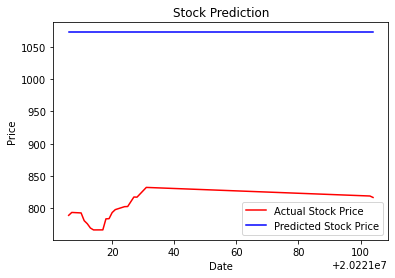

In [130]:
plt.plot(df_stock_test['Date'], df_stock_test['Close_Price'], color='red', label='Actual Stock Price')
plt.plot(df_stock_test['Date'], pred_stack, color='blue', label='Predicted Stock Price')
plt.title('Stock Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## **Pipeline Model-2**

In [131]:
# Difference between Pipeline and make_pipeline
# In Pipeline, we need to give name of regressor/classifier string.
# In make_pipeline, no need to give names.
from sklearn.linear_model import LassoCV
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.linear_model import RidgeCV
from sklearn.ensemble import StackingRegressor

lasso_pipeline = make_pipeline(StandardScaler(), LassoCV())
rf_pipeline = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=42))
gbdt_pipeline = make_pipeline(StandardScaler(), HistGradientBoostingRegressor(random_state=0))

estimators = [
    ("Random Forest", rf_pipeline),
    ("Lasso", lasso_pipeline),
    ("Gradient Boosting", gbdt_pipeline)
]

stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())
stacking_regressor




StackingRegressor(estimators=[('Random Forest',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('randomforestregressor',
                                                RandomForestRegressor(random_state=42))])),
                              ('Lasso',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('lassocv', LassoCV())])),
                              ('Gradient Boosting',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('histgradientboostingregressor',
                                                HistGradientBoostingRegressor(random_state=0))]))],
                  final_estimator=RidgeCV

In [132]:
stacking_regressor.fit(df_stock_train_array_x, df_stock_train_array_y)

StackingRegressor(estimators=[('Random Forest',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('randomforestregressor',
                                                RandomForestRegressor(random_state=42))])),
                              ('Lasso',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('lassocv', LassoCV())])),
                              ('Gradient Boosting',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('histgradientboostingregressor',
                                                HistGradientBoostingRegressor(random_state=0))]))],
                  final_estimator=RidgeCV

In [133]:
df_stock_test_array_x = df_stock_test['Date'].values.reshape(-1,1)

In [134]:
# Prediction
pred_stack = stacking_regressor.predict(df_stock_test_array_x)
#pred_stack = cross_val_predict(estimators, X, y, n_jobs=2, verbose=0)

In [135]:
pred_stack

array([1065.97460299, 1065.97300048, 1065.96819294, 1065.96659042,
       1065.96498791, 1065.9633854 , 1065.96178289, 1065.95697535,
       1065.95537284, 1065.95377032, 1065.95216781, 1065.9505653 ,
       1065.94575776, 1065.94415525, 1065.94095022, 1065.93934771,
       1065.93454017, 1065.81915927, 1065.81755675])

In [136]:
df_stock_test['Close_Price']

Date
2022-10-06    788.60
2022-10-07    793.10
2022-10-10    792.35
2022-10-11    780.30
2022-10-12    775.55
2022-10-13    768.90
2022-10-14    765.95
2022-10-17    766.00
2022-10-18    783.15
2022-10-19    783.40
2022-10-20    792.90
2022-10-21    797.45
2022-10-24    802.10
2022-10-25    802.30
2022-10-27    817.10
2022-10-28    816.85
2022-10-31    832.00
2022-11-03    818.65
2022-11-04    816.40
Name: Close_Price, dtype: float64

**Evaluation of Model**

In [137]:
mse = mean_squared_error(df_stock_test['Close_Price'], pred_stack)
rmse_stack2 = mse**.5
print(mse)
print(rmse_stack2)

74106.32717439684
272.2247732562135


**Understanding the predictions by charts**

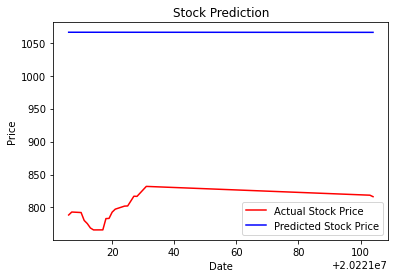

In [138]:
plt.plot(df_stock_test['Date'], df_stock_test['Close_Price'], color='red', label='Actual Stock Price')
plt.plot(df_stock_test['Date'], pred_stack, color='blue', label='Predicted Stock Price')
plt.title('Stock Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## **Smoothed Exponential Moving Average**

In [139]:
# Set Date column as index 
df_stock=df_stock.reset_index(drop=True)
df_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1726 entries, 0 to 1725
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1726 non-null   int64  
 1   Close_Price  1726 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 27.1 KB


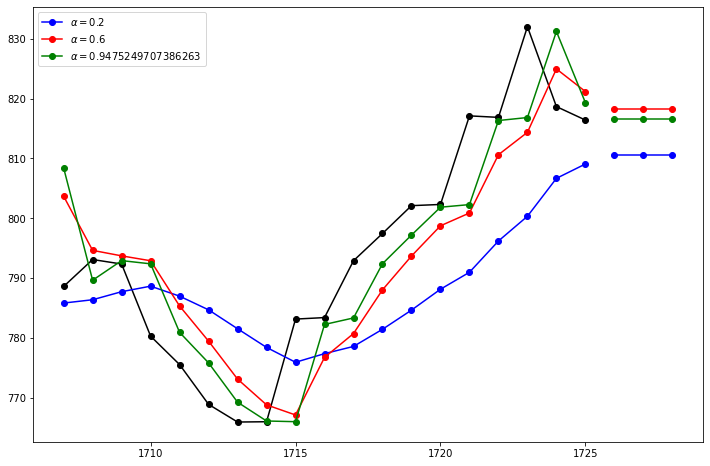

In [140]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing

fit1 = SimpleExpSmoothing(df_stock['Close_Price'], initialization_method="heuristic").fit(
    smoothing_level=0.2, optimized=False
)
fcast1 = fit1.forecast(3).rename(r"$\alpha=0.2$")
fit2 = SimpleExpSmoothing(df_stock['Close_Price'], initialization_method="heuristic").fit(
    smoothing_level=0.6, optimized=False
)
fcast2 = fit2.forecast(3).rename(r"$\alpha=0.6$")
fit3 = SimpleExpSmoothing(df_stock['Close_Price'], initialization_method="estimated").fit()
fcast3 = fit3.forecast(3).rename(r"$\alpha=%s$" % fit3.model.params["smoothing_level"])


plt.figure(figsize=(12, 8))
plt.plot(df_stock['Close_Price'].tail(19), marker="o", color="black")
plt.plot(fit1.fittedvalues[-19:], marker="o", color="blue")
(line1,) = plt.plot(fcast1, marker="o", color="blue")
plt.plot(fit2.fittedvalues[-19:], marker="o", color="red")
(line2,) = plt.plot(fcast2, marker="o", color="red")
plt.plot(fit3.fittedvalues[-19:], marker="o", color="green")
(line3,) = plt.plot(fcast3, marker="o", color="green")
plt.legend([line1, line2, line3], [fcast1.name, fcast2.name, fcast3.name])


In [141]:
fcast3

1726    816.552637
1727    816.552637
1728    816.552637
Name: $\alpha=0.9475249707386263$, dtype: float64

In [142]:
fit1.fittedvalues

0       331.053333
1       331.892667
2       331.844133
3       331.855307
4       332.264245
           ...    
1721    790.969771
1722    796.195817
1723    800.326654
1724    806.661323
1725    809.059058
Length: 1726, dtype: float64

**Evaluation of Model**

In [143]:
mse = mean_squared_error(df_stock['Close_Price'], fit3.fittedvalues)
rmse_sema = mse**.5
print(mse)
print(rmse_sema)

89.0665186730228
9.43750595618476


# **Comparision of Various Models and Conclusion**

In [144]:
# Display RMSE values of all four models
df_rmse = pd.DataFrame ({'Model Name': ['Ramdom Forest', 'Adaboost', 'Keras', 'ARIMA', 'Pipeline_1', 'Pipeline_2', 'SEMA'], 
                         'RMSE Value': [rmse_rf, rmse_ab, rmse_kr, rmse_arima, rmse_stack1, rmse_stack2, rmse_sema]})
df_rmse

,Model Name,RMSE Value
0,Ramdom Forest,21.153094
1,Adaboost,21.956667
2,Keras,327.565279
3,ARIMA,22.389771
4,Pipeline_1,279.420194
5,Pipeline_2,272.224773
6,SEMA,9.437506


Final Conclusion: By analyzing RMSE values and prediction charts for closeness of predicted values to actual values, we can certainly confirm that Smoothed Exponential Moving Average is the best prediction method. 